In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, defaultdict
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython import get_ipython
from IPython import display
from dynamic_env import TaskEnv_drift

In [10]:

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class MetaDQNAgent:
    def __init__(self, env):
        self.env = env
        
        # Initialize state and action encoders
        self.state_encoder = StateActionEncoder(env.states)
        self.action_encoder = StateActionEncoder(env.motions)
        
        self.state_size = len(env.states)
        self.action_size = len(env.motions)
        
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 16
        self.update_target_every = 100
        
        # Main network
        self.model = DQN(self.state_size, self.action_size)
        # Target network (for stability)
        self.target_model = DQN(self.state_size, self.action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Meta-learning components
        self.meta_optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.fast_weights = None
        self.meta_batch_size = 5
        
        # Tracking
        self.rewards_history = []
        self.epsilons_history = []
        self.loss_history = []
        self.adaptation_scores = []
        
        # For action masking
        self.valid_actions_cache = {}

    def remember(self, state, action, reward, next_state, done):
        state_enc = self.state_encoder.encode(state)
        action_idx = self.action_encoder.encode(action)
        next_state_enc = self.state_encoder.encode(next_state)
        self.memory.append((state_enc, action_idx, reward, next_state_enc, done))
        

    
    def get_valid_actions(self, state):
        """Cache valid actions for each state to handle action masking"""
        if state not in self.valid_actions_cache:
            # Get all possible actions from environment
            self.valid_actions_cache[state] = list(range(len(self.env.motions)))
        return self.valid_actions_cache[state]
    
    def act(self, state, training=True):
        valid_actions = self.get_valid_actions(state)
        
        if training and np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)
        
        state_enc = self.state_encoder.encode(state)
        state_enc = torch.FloatTensor(state_enc).unsqueeze(0)
        
        with torch.no_grad():
            action_values = self.model(state_enc)
        
        # Convert to numpy and mask invalid actions
        action_values = action_values.squeeze().numpy()
        masked_values = -np.inf * np.ones_like(action_values)
        masked_values[valid_actions] = action_values[valid_actions]
        
        return np.argmax(masked_values)
    
    """def compute_loss(self, batch, model):
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to tensors with proper shapes
        states = torch.FloatTensor(np.array(states))  # shape: [batch_size, state_dim]
        next_states = torch.FloatTensor(np.array(next_states))  # shape: [batch_size, state_dim]
        actions = torch.LongTensor(actions).unsqueeze(1)  # shape: [batch_size, 1]
        rewards = torch.FloatTensor(rewards).unsqueeze(1)  # shape: [batch_size, 1]
        dones = torch.FloatTensor(dones).unsqueeze(1)  # shape: [batch_size, 1]
        print(actions.dim())


        # Get Q values for all actions
        q_values = model(states)  # shape: [batch_size, action_size]
                        # 在compute_loss中添加
        assert q_values.dim() == 2, f"q_values should be 2D, got {q_values.dim()}"
        assert actions.dim() == 2, f"actions should be 2D, got {actions.dim()}"
        assert actions.shape[0] == q_values.shape[0], "Batch size mismatch"
        assert actions.dtype == torch.long, f"Actions should be long type, got {actions.dtype}"
        print(f"Action space size: {self.action_size}")
        print(f"Q-values action dim: {q_values.shape[1]}")
        print(f"Max action index: {torch.max(actions)}")
        assert torch.max(actions) < self.action_size, "Action index out of bounds"
        
        # Gather the Q values for the taken actions
        current_q = q_values.gather(1, actions)  # shape: [batch_size, 1]
        
        # Compute target Q values
        with torch.no_grad():
            next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)  # shape: [batch_size, 1]
        target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss
        loss = F.mse_loss(current_q, target_q)

        return loss"""
    def compute_loss(self, batch, model):
            # 解包批次数据
        states, actions, rewards, next_states, dones = zip(*batch)  
    # 转为张量并确保正确形状
        states = torch.FloatTensor(np.array(states))  # shape: [batch_size, state_dim]
        next_states = torch.FloatTensor(np.array(next_states))  # shape: [batch_size, state_dim] 
    # 关键修正：处理actions维度
        actions = torch.LongTensor(actions)  # 先转为1D张量
        if actions.dim() == 1:
            actions = actions.unsqueeze(1)  # 转为[batch_size, 1]
        elif actions.dim() > 2:
            actions = actions.squeeze()  # 去除多余维度
        if actions.dim() == 1:
            actions = actions.unsqueeze(1)
    
        rewards = torch.FloatTensor(rewards).unsqueeze(1)  # [batch_size, 1]
        dones = torch.FloatTensor(dones).unsqueeze(1)      # [batch_size, 1]
        self._validate_shapes(states, actions, rewards, next_states, dones)
        # 获取Q值
        q_values = model(states)  # [batch_size, action_size]
        
        # 收集实际采取动作的Q值
        current_q = q_values.gather(1, actions)  # [batch_size, 1]
        
        # 计算目标Q值
        with torch.no_grad():
            next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        return F.mse_loss(current_q, target_q)

    
    def _validate_shapes(self, states, actions, rewards, next_states, dones):
        """验证所有张量的形状是否正确"""
        assert states.dim() == 2, f"States should be 2D, got {states.dim()}"
        assert actions.dim() == 2, f"Actions should be 2D, got {actions.dim()}"
        assert rewards.dim() == 2, f"Rewards should be 2D, got {rewards.dim()}"
        assert next_states.dim() == 2, f"Next states should be 2D, got {next_states.dim()}"
        assert dones.dim() == 2, f"Dones should be 2D, got {dones.dim()}"
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from memory
        batch = random.sample(self.memory, self.batch_size)
        loss = self.compute_loss(batch, self.model)
        
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def meta_update(self):
        if len(self.memory) < self.meta_batch_size * self.batch_size:
            return 0
        
        # 保存原始权重
        original_weights = {k: v.clone() for k, v in self.model.named_parameters()}
        
        task_losses = []
        for _ in range(self.meta_batch_size):
            # 采样一个任务批次
            batch = random.sample(self.memory, self.batch_size)
            
            # 内循环：计算梯度并创建快速权重
            with torch.enable_grad():  # 确保计算梯度
                loss = self.compute_loss(batch, self.model)
                gradients = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)
                
                # 创建快速权重（保持计算图连接）
                fast_weights = {
                    name: param - self.learning_rate * grad
                    for (name, param), grad in zip(self.model.named_parameters(), gradients)
                }
            
            # 计算快速权重下的损失（保持计算图）
            with torch.enable_grad():
                # 临时使用快速权重进行前向传播
                def fast_forward(x):
                    x = F.relu(F.linear(x, fast_weights['fc1.weight'], fast_weights['fc1.bias']))
                    x = F.relu(F.linear(x, fast_weights['fc2.weight'], fast_weights['fc2.bias']))
                    return F.linear(x, fast_weights['fc3.weight'], fast_weights['fc3.bias'])
                
                task_loss = self.compute_loss(batch, fast_forward)
                task_losses.append(task_loss)
        
        # 外循环：元更新
        meta_loss = torch.mean(torch.stack(task_losses))
        self.meta_optimizer.zero_grad()
        meta_loss.backward()
        self.meta_optimizer.step()
        
        return meta_loss.item()
    
    def train(self, episodes, drift_episode=None):
        for e in tqdm(range(episodes)):
            # Apply drift at specified episode
            if drift_episode is not None and e == drift_episode:
                self.apply_drift()
            
            state = self.env.reset()
            total_reward = 0
            done = False
            
            while not done:
                action_idx = self.act(state)
                action = self.env.motions[action_idx]  # Convert index back to action string
                next_state, reward, done, _ = self.env.step(action_idx)
                
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                
                # Standard replay
                loss = self.replay()
                if loss:
                    self.loss_history.append(loss)
                
                # Meta-update less frequently
                if e % 10 == 0:
                    meta_loss = self.meta_update()
            
            # Update target network periodically
            if e % self.update_target_every == 0:
                self.target_model.load_state_dict(self.model.state_dict())
            
            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
            # Track progress
            self.rewards_history.append(total_reward)
            self.epsilons_history.append(self.epsilon)
            
            # Evaluate adaptation every 50 episodes
            if e % 50 == 0:
                adaptation_score = self.evaluate_adaptation()
                self.adaptation_scores.append(adaptation_score)
                print(f"Episode: {e}, Reward: {total_reward:.2f}, Adapt Score: {adaptation_score:.2f}, Epsilon: {self.epsilon:.2f}")


                
    def apply_drift(self):
        """Handle environment drift"""
        print("\nApplying environment drift...")
        self.env.set_flag()
        self.env.drift(add_actions=0, add_states=0)#only transition metrix change
        
        # Update encoders with new states/actions
        old_state_encoder = self.state_encoder
        old_action_encoder = self.action_encoder
        
        self.state_encoder = StateActionEncoder(self.env.states)
        self.action_encoder = StateActionEncoder(self.env.motions)
        
        # Create new networks with updated sizes
        old_model = self.model
        self.state_size = len(self.env.states)
        self.action_size = len(self.env.motions)
        
        self.model = DQN(self.state_size, self.action_size)
        self.target_model = DQN(self.state_size, self.action_size)
        
        # Initialize new layers with old weights where possible
        self._transfer_weights(old_model, old_state_encoder, old_action_encoder)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.meta_optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        
        # Reset valid actions cache
        self.valid_actions_cache = {}
        
        print(f"Updated to {self.state_size} states and {self.action_size} actions")
    
    def _transfer_weights(self, old_model, old_state_encoder, old_action_encoder):
        """Transfer weights from old model to new model, handling dimension changes"""
        # Create mapping from old to new indices
        state_mapping = self._create_mapping(old_state_encoder.vocab, self.state_encoder.vocab)
        action_mapping = self._create_mapping(old_action_encoder.vocab, self.action_encoder.vocab)
        
        # Transfer weights layer by layer
        with torch.no_grad():
            # FC1 layer (input is state)
            self._transfer_fc_layer(old_model.fc1, self.model.fc1, state_mapping, None)
            
            # FC2 layer (no dimension changes)
            if old_model.fc2.weight.shape == self.model.fc2.weight.shape:
                self.model.fc2.load_state_dict(old_model.fc2.state_dict())
            
            # FC3 layer (output is action)
            self._transfer_fc_layer(old_model.fc3, self.model.fc3, None, action_mapping)
    
    def _transfer_fc_layer(self, old_layer, new_layer, input_mapping, output_mapping):
        """Helper function to transfer weights for a fully connected layer"""
        old_weights = old_layer.weight.data
        old_bias = old_layer.bias.data if old_layer.bias is not None else None
        
        new_weights = torch.zeros_like(new_layer.weight.data)
        new_bias = torch.zeros_like(new_layer.bias.data) if new_layer.bias is not None else None
        
        # Handle input dimension mapping
        if input_mapping is not None:
            for new_in, old_in in input_mapping.items():
                new_weights[:, new_in] = old_weights[:, old_in]
        else:
            min_in = min(old_weights.shape[1], new_weights.shape[1])
            new_weights[:, :min_in] = old_weights[:, :min_in]
        
        # Handle output dimension mapping
        if output_mapping is not None:
            for new_out, old_out in output_mapping.items():
                new_weights[new_out, :] = old_weights[old_out, :]
                if new_bias is not None:
                    new_bias[new_out] = old_bias[old_out]
        else:
            min_out = min(old_weights.shape[0], new_weights.shape[0])
            new_weights[:min_out, :] = old_weights[:min_out, :]
            if new_bias is not None:
                new_bias[:min_out] = old_bias[:min_out]
        
        new_layer.weight.data = new_weights
        if new_bias is not None:
            new_layer.bias.data = new_bias
    
    def _create_mapping(self, old_vocab, new_vocab):
        """Create mapping from old to new indices for common elements"""
        mapping = {}
        for new_idx, item in enumerate(new_vocab):
            if item in old_vocab:
                old_idx = old_vocab.index(item)
                mapping[new_idx] = old_idx
        return mapping
    
    def evaluate_adaptation(self, num_episodes=10):
        """Evaluate agent's current performance"""
        total_rewards = 0
        for _ in range(num_episodes):
            state = self.env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                action_idx = self.act(state, training=False)
                next_state, reward, done, _ = self.env.step(action_idx)
                state = next_state
                episode_reward += reward
            
            total_rewards += episode_reward
        
        return total_rewards / num_episodes
    
    def plot_training(self, show_window=50):
        plt.figure(figsize=(15, 5))
        
        # 1. Plot rewards
        plt.subplot(1, 3, 1)
        
        # Ensure we have enough episodes for moving average
        if len(self.rewards_history) >= show_window:
            moving_avg = np.convolve(self.rewards_history, np.ones(show_window)/show_window, mode='valid')
            # Correct x-axis coordinates for moving average
            x_ma = np.arange(show_window-1, len(self.rewards_history))
            plt.plot(x_ma, moving_avg, 'r-', linewidth=2, label=f'MA({show_window})')
        
        # Plot raw rewards
        plt.plot(self.rewards_history, alpha=0.3, label='Raw')
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()
        
        # 2. Plot epsilon decay
        plt.subplot(1, 3, 2)
        plt.plot(self.epsilons_history)
        plt.title('Epsilon Decay')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        
        # 3. Plot adaptation scores
        plt.subplot(1, 3, 3)
        if len(self.adaptation_scores) > 0:
            # Calculate correct x-axis positions for adaptation scores
            eval_every = len(self.rewards_history) / len(self.adaptation_scores)
            x = np.arange(0, len(self.rewards_history), eval_every)
            # Ensure we don't have more points than scores
            x = x[:len(self.adaptation_scores)]
            plt.plot(x, self.adaptation_scores, 'g-', marker='o')
            plt.title('Adaptation Scores')
            plt.xlabel('Episode')
            plt.ylabel('Avg Reward (eval)')
        
        plt.tight_layout()
        plt.show()

class StateActionEncoder:
    """Helper class to handle one-hot encoding of states and actions"""
    def __init__(self, items):
        self.vocab = sorted(items)
        self.item_to_idx = {item: idx for idx, item in enumerate(self.vocab)}
    
    def encode(self, item):
        """Convert item to one-hot encoding"""
        if item not in self.item_to_idx:
            # Handle unknown items (shouldn't happen in our case)
            return np.zeros(len(self.vocab))
        encoding = np.zeros(len(self.vocab))
        encoding[self.item_to_idx[item]] = 1
        #print(self.item_to_idx[item])
        #print(encoding)
        return encoding
    
    def decode(self, encoding):
        """Convert one-hot encoding back to item"""
        idx = np.argmax(encoding)
        return self.vocab[idx]
    



/Users/veetin/Desktop/drifttest_pa/main/dynamic_env.py:47: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错
  0%|          | 0/500 [

/var/folders/d0/tc19xqb91j90rtgsvst2cg2h0000gp/T/ipykernel_13896/284055512.py:153: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(current_q, target_q)
  5%|▍         | 24/500 [00:00<00:02, 237.31it/s]

Episode: 0, Reward: 0.00, Adapt Score: -1.80, Epsilon: 0.99


 14%|█▍        | 70/500 [00:00<00:03, 123.02it/s]

Episode: 50, Reward: -9.00, Adapt Score: -10.60, Epsilon: 0.77


 18%|█▊        | 91/500 [00:00<00:02, 145.36it/s]/var/folders/d0/tc19xqb91j90rtgsvst2cg2h0000gp/T/ipykernel_13896/284055512.py:153: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(current_q, target_q)
 22%|██▏       | 109/500 [00:00<00:02, 144.95it/s]


Applying environment drift...
drift happen
Updated to 5 states and 7 actions
Episode: 100, Reward: 0.00, Adapt Score: -12.60, Epsilon: 0.60


 33%|███▎      | 164/500 [00:01<00:02, 146.23it/s]

Episode: 150, Reward: -4.00, Adapt Score: -9.40, Epsilon: 0.47


 44%|████▍     | 219/500 [00:01<00:02, 113.10it/s]

Episode: 200, Reward: -11.00, Adapt Score: -14.50, Epsilon: 0.37


 55%|█████▍    | 274/500 [00:02<00:01, 125.18it/s]

Episode: 250, Reward: -7.00, Adapt Score: -8.20, Epsilon: 0.28


 63%|██████▎   | 317/500 [00:02<00:01, 130.46it/s]

Episode: 300, Reward: 1.00, Adapt Score: -13.70, Epsilon: 0.22


 74%|███████▎  | 368/500 [00:02<00:01, 93.96it/s] 

Episode: 350, Reward: -26.00, Adapt Score: -5.40, Epsilon: 0.17


 84%|████████▍ | 421/500 [00:03<00:00, 94.24it/s]

Episode: 400, Reward: -5.00, Adapt Score: -10.50, Epsilon: 0.13


 93%|█████████▎| 467/500 [00:04<00:00, 101.01it/s]

Episode: 450, Reward: -11.00, Adapt Score: -12.00, Epsilon: 0.10


100%|██████████| 500/500 [00:04<00:00, 115.90it/s]


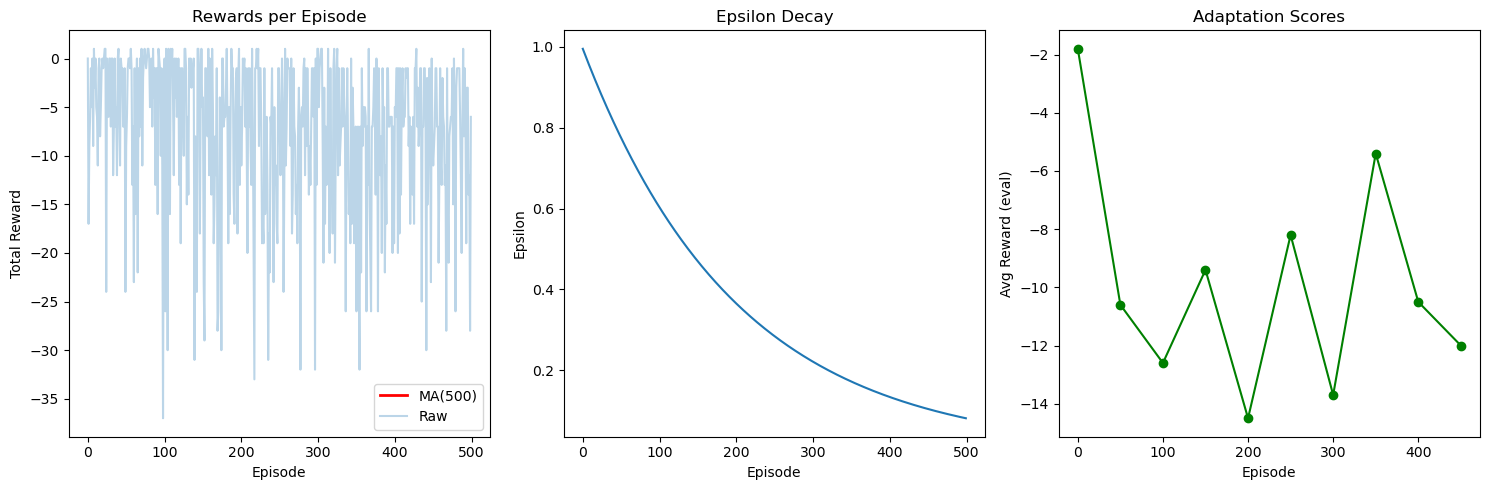

/Users/veetin/Desktop/drifttest_pa/main/dynamic_env.py:47: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错
  0%|          | 0/500 [

Episode: 0, Reward: -15.00, Adapt Score: -3.30, Epsilon: 0.99


 15%|█▍        | 73/500 [00:00<00:03, 135.20it/s]

Episode: 50, Reward: -1.00, Adapt Score: -2.80, Epsilon: 0.77


 24%|██▍       | 121/500 [00:00<00:02, 130.77it/s]

Episode: 100, Reward: -1.00, Adapt Score: -5.70, Epsilon: 0.60


 36%|███▌      | 181/500 [00:01<00:02, 128.47it/s]

Episode: 150, Reward: 1.00, Adapt Score: -4.10, Epsilon: 0.47


 46%|████▌     | 231/500 [00:01<00:01, 144.48it/s]

Episode: 200, Reward: -1.00, Adapt Score: -0.40, Epsilon: 0.37


 54%|█████▍    | 271/500 [00:01<00:01, 157.44it/s]

Episode: 250, Reward: -5.00, Adapt Score: -8.60, Epsilon: 0.28


 64%|██████▍   | 322/500 [00:02<00:01, 140.48it/s]

Episode: 300, Reward: 1.00, Adapt Score: -3.50, Epsilon: 0.22


 76%|███████▌  | 381/500 [00:02<00:00, 169.82it/s]

Episode: 350, Reward: 0.00, Adapt Score: -4.10, Epsilon: 0.17


 83%|████████▎ | 415/500 [00:02<00:00, 142.82it/s]

Episode: 400, Reward: -5.00, Adapt Score: -6.10, Epsilon: 0.13


 95%|█████████▍| 473/500 [00:03<00:00, 157.60it/s]

Episode: 450, Reward: 0.00, Adapt Score: -4.00, Epsilon: 0.10


100%|██████████| 500/500 [00:03<00:00, 144.55it/s]


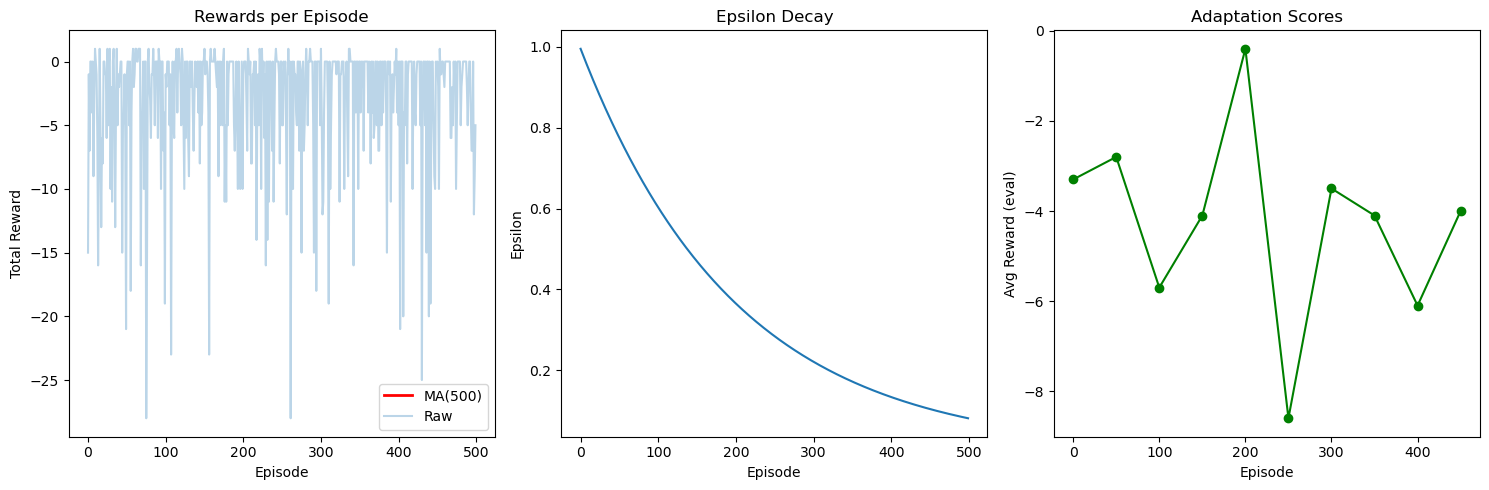

In [ ]:
# Usage example
if __name__ == "__main__":
    #without drift as comparasion
    env = TaskEnv_drift()
    # Initialize agent
    agent_nodrift = MetaDQNAgent(env)
    # Train with drift at episode 500
    agent_nodrift.train(episodes=500, drift_episode=None)#without drift
    # Plot training results
    agent_nodrift.plot_training(show_window=500)


    env = TaskEnv_drift()
    # Initialize agent
    agent = MetaDQNAgent(env)
    # Train with drift at episode 500
    agent.train(episodes=500, drift_episode=100)#only drift in transition metrix
    # Plot training results
    agent.plot_training(show_window=500)

In [8]:
def compare_reward(r1,r2):
    plt.figure(figsize=(10, 6))  # Set figure size (optional)
    episodes = range(1, len(r1) + 1)
# Plot both reward lists
    plt.plot(episodes, r1, label=' drift', linestyle='-')
    plt.plot(episodes, r2, label=' no drift', linestyle='--')

# Add labels and title
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Comparison of Two Reward Lists Over Episodes')
    plt.legend()  # Show legend


# Show the plot
    plt.show()

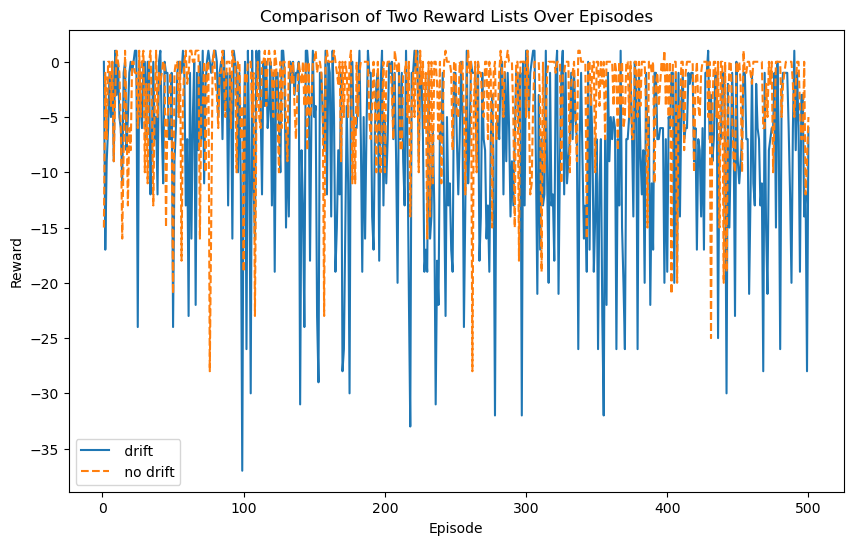

In [9]:
r1 = agent.rewards_history
r2 = agent_nodrift.rewards_history
compare_reward(r1,r2)